In [1]:
 ! pip install pyDOE

In [2]:
import torch
import torch.autograd as autograd         # graphe de calcul
from torch import Tensor                  # noeud tensoriel dans le graphe de calcul
import torch.nn as nn                     # réseaux de neurones
import torch.optim as optim               # optimiseurs, par exemple descente de gradient, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Échantillonnage hypercube latin
import scipy.io

#Définir le type par défaut sur float32
torch.set_default_dtype(torch.float)

#Générateur de nombres aléatoires PyTorch
torch.manual_seed(1234)

# Générateurs de nombres aléatoires dans d'autres bibliothèques
np.random.seed(1234)

# Configuration du dispositif
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cpu


In [3]:
steps = 20000
lr = 1e-3
layers = np.array([2, 32, 32, 1])  # couches cachées
# Pour générer de nouvelles données :
x_min = 0
x_max = 1
t_min = 0
t_max = 1
total_points_x = 200
total_points_t = 100
# Nu: Nombre de points d'entraînement # Nf: Nombre de points de collocation (Évaluation de l'EDP)
Nu = 100
Nf = 10000

In [4]:
def f_real(x,t):
  return torch.exp(-t)*(torch.sin(np.pi*x))

In [5]:
import torch
import torch.autograd as autograd         # graphe de calcul
from torch import Tensor                  # noeud tensoriel dans le graphe de calcul
import torch.nn as nn                     # réseaux de neurones
import torch.optim as optim               # optimiseurs, par exemple descente de gradient, ADAM, etc.

import numpy as np
import time

class FCN(nn.Module):
    ##Réseau de neurones
    def __init__(self, layers):
        super().__init__()  # appelle __init__ de la classe parente
        'fonction d activation'
        self.activation = nn.Tanh()
        'fonction de perte'
        self.loss_function = nn.MSELoss(reduction='mean')
        'Initialise le réseau de neurones comme une liste en utilisant nn.Modulelist'
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.iter = 0  # Pour l'optimiseur
        'Initialisation normale de Xavier'
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # met les biais à zéro
            nn.init.zeros_(self.linears[i].bias.data)

    'passage avant'
    def forward(self, x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        a = x.float()
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(z)
        a = self.linears[-1](a)
        return a

    'Fonctions de perte'
    # Perte des conditions aux limites (BC)
    def lossBC(self, x_BC, y_BC):
        loss_BC = self.loss_function(self.forward(x_BC), y_BC)
        return loss_BC

    # Perte de l'équation différentielle partielle (PDE)
    def lossPDE(self, x_PDE):
        g = x_PDE.clone()
        g.requires_grad = True  # Activer la différentiation
        f = self.forward(g)
        f_x_t = autograd.grad(f, g, torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]  # première dérivée
        f_xx_tt = autograd.grad(f_x_t, g, torch.ones(g.shape).to(device), create_graph=True)[0]  # deuxième dérivée
        f_t = f_x_t[:, [1]]  # nous sélectionnons le 2e élément pour t (le premier est x) (Rappelez-vous que l'entrée X=[x,t])
        f_xx = f_xx_tt[:, [0]]  # nous sélectionnons le 1er élément pour x (le deuxième est t) (Rappelez-vous que l'entrée X=[x,t])
        f = f_t - f_xx + torch.exp(-g[:, 1:]) * (torch.sin(np.pi * g[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * g[:, 0:1]))
        return self.loss_function(f, f_hat)

    def loss(self, x_BC, y_BC, x_PDE):
        loss_bc = self.lossBC(x_BC, y_BC)
        loss_pde = self.lossPDE(x_PDE)
        return loss_bc + loss_pde

    # Optimiseur X_train_Nu, Y_train_Nu, X_train_Nf
    def closure(self):
        optimizer.zero_grad()
        loss = self.loss(X_train_Nu, Y_train_Nu, X_train_Nf)
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            loss2 = self.lossBC(X_test, Y_test)
            print("Erreur d'entraînement:", loss.detach().cpu().numpy(), "---Erreur de test:", loss2.detach().cpu().numpy())
        return loss


In [6]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1) 
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()
def plot3D_Matrix(x,t,y):
  X,T= x,t
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

C:\Users\HOME\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


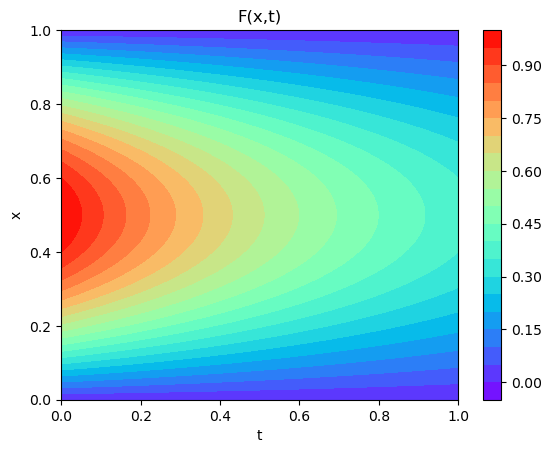

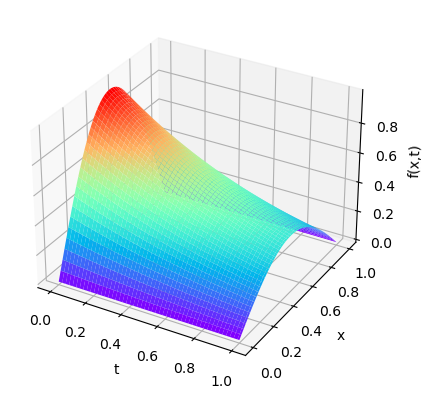

In [7]:
x=torch.linspace(x_min,x_max,total_points_x).view(-1,1)
t=torch.linspace(t_min,t_max,total_points_t).view(-1,1)
# Creation de  mesh 
X,T=torch.meshgrid(x.squeeze(1),t.squeeze(1))
# Fonction analytique
y_real=f_real(X,T)
plot3D(x,t,y_real) 

In [8]:
print(x.shape,t.shape,y_real.shape)
print(X.shape,T.shape)
# Transformer  la mesh en un vecteur de   2-columns
x_test=torch.hstack((X.transpose(1,0).flatten()[:,None],T.transpose(1,0).flatten()[:,None]))
y_test=y_real.transpose(1,0).flatten()[:,None] 
# Domain bounds
lb=x_test[0] #premiere valeur
ub=x_test[-1] #derniere valeur 
print(x_test.shape,y_test.shape)
print(lb,ub)

torch.Size([200, 1]) torch.Size([100, 1]) torch.Size([200, 100])
torch.Size([200, 100]) torch.Size([200, 100])
torch.Size([20000, 2]) torch.Size([20000, 1])
tensor([0., 0.]) tensor([1., 1.])


In [9]:
# Condition initiale
# Bord gauche : x(x,0) = sin(x) -> xmin <= x <= xmax; t = 0
left_X = torch.hstack((X[:,0][:,None], T[:,0][:,None]))  # Première colonne # Le [:,None] sert à donner la bonne dimension
left_Y = torch.sin(np.pi * left_X[:,0]).unsqueeze(1)
# Conditions aux limites
# Bord inférieur : x = min; tmin <= t <= tmax
bottom_X = torch.hstack((X[0,:][:,None], T[0,:][:,None]))  # Première ligne # Le [:,None] sert à donner la bonne dimension
bottom_Y = torch.zeros(bottom_X.shape[0], 1)
# Bord supérieur : x = max; 0 <= t <= 1
top_X = torch.hstack((X[-1,:][:,None], T[-1,:][:,None]))  # Dernière ligne # Le [:,None] sert à donner la bonne dimension
top_Y = torch.zeros(top_X.shape[0], 1)
# Regrouper toutes les données d'entraînement dans le même ensemble de données
X_train = torch.vstack([left_X, bottom_X, top_X])
Y_train = torch.vstack([left_Y, bottom_Y, top_Y])
# Choisir (Nu) points parmi nos données d'entraînement disponibles :
idx = np.random.choice(X_train.shape[0], Nu, replace=False)
X_train_Nu = X_train[idx,:]
Y_train_Nu = Y_train[idx,:]
# Points de collocation (Évaluer notre EDP)
# Choisir (Nf) points (hypercube latin)
X_train_Nf = lb + (ub - lb) * lhs(2, Nf)  # 2 car les entrées sont x et t
X_train_Nf = torch.vstack((X_train_Nf, X_train_Nu))  # Ajouter les points d'entraînement aux points de collocation


In [10]:
print("Formes originales de X et Y:", X.shape, y_real.shape)
print("Formes des bords pour les bords:", left_X.shape, bottom_X.shape, top_X.shape)
print("Données d'entraînement disponibles:", X_train.shape, Y_train.shape)
print("Données d'entraînement finales:", X_train_Nu.shape, Y_train_Nu.shape)
print("Points de collocation totaux:", X_train_Nf.shape)


Formes originales de X et Y: torch.Size([200, 100]) torch.Size([200, 100])
Formes des bords pour les bords: torch.Size([200, 2]) torch.Size([100, 2]) torch.Size([100, 2])
Données d'entraînement disponibles: torch.Size([400, 2]) torch.Size([400, 1])
Données d'entraînement finales: torch.Size([100, 2]) torch.Size([100, 1])
Points de collocation totaux: torch.Size([10100, 2])


In [11]:
torch.manual_seed(123)
# Stocker les tenseurs sur le GPU
X_train_Nu = X_train_Nu.float().to(device)  # Points d'entraînement (BC)
Y_train_Nu = Y_train_Nu.float().to(device)  # Points d'entraînement (BC)
X_train_Nf = X_train_Nf.float().to(device)  # Points de collocation
f_hat = torch.zeros(X_train_Nf.shape[0], 1).to(device)  # fonction à minimiser

X_test = x_test.float().to(device)  # le jeu de données d'entrée (complet)
Y_test = y_test.float().to(device)  # la solution réelle

# Créer le modèle
PINN = FCN(layers)
PINN.to(device)
print(PINN)
params = list(PINN.parameters())
optimizer = torch.optim.Adam(PINN.parameters(), lr=lr, amsgrad=False)
'''
'Optimiseur L-BFGS'
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=lr,
                              max_iter=steps,
                              max_eval=None,
                              tolerance_grad=1e-05,
                              tolerance_change=1e-09,
                              history_size=100,
                              line_search_fn='strong_wolfe')'''
start_time = time.time()


FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [12]:

for i in range(steps):
    if i==0:
      print("Training Loss-----Test Loss")
    loss = PINN.loss(X_train_Nu,Y_train_Nu,X_train_Nf)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i%(steps/10)==0:
      with torch.no_grad():
        test_loss=PINN.lossBC(X_test,Y_test)
      print(loss.detach().cpu().numpy(),'---',test_loss.detach().cpu().numpy())

Training Loss-----Test Loss
14.943946 --- 0.1326673
0.0031209267 --- 0.002733545
0.000896847 --- 0.0013913367
0.00043744984 --- 0.0013205463
0.00022225892 --- 0.0014789535
0.00025182933 --- 0.0015921486
0.00015323698 --- 0.0017314329
0.0001508997 --- 0.0017552995
0.00013313036 --- 0.0017692688
0.0001230917 --- 0.0017699709


In [13]:
y1=PINN(X_test)
x1=X_test[:,0]
t1=X_test[:,1]
arr_x1=x1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y1=y1.reshape(shape=[100,200]).transpose(1,0).detach().cpu()
arr_y_test=y_test.reshape(shape=[100,200]).transpose(1,0).detach().cpu()

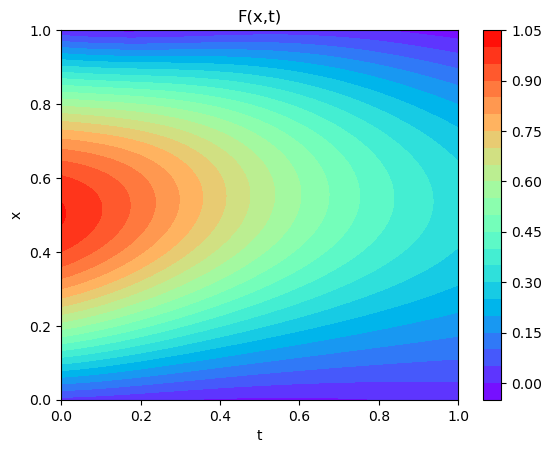

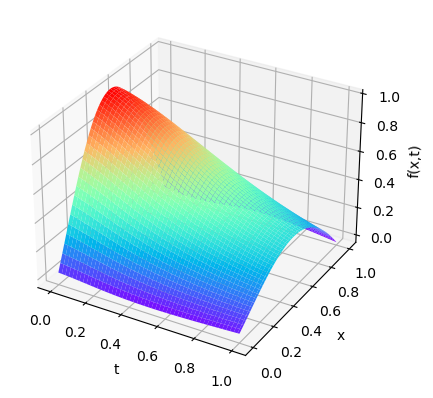

In [14]:
plot3D_Matrix(arr_x1,arr_T1,arr_y1)

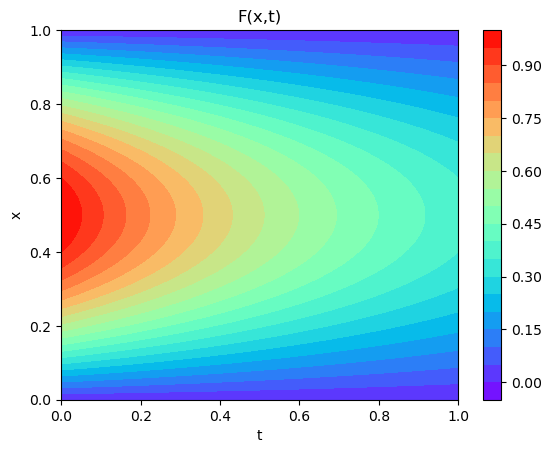

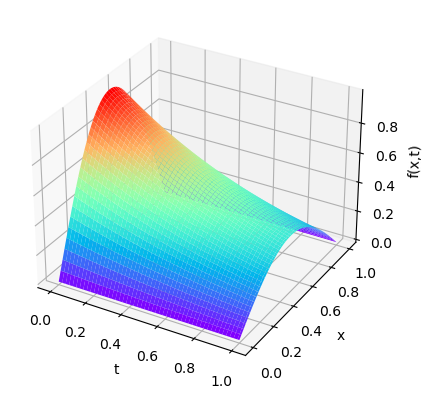

In [15]:
plot3D_Matrix(X,T,y_real)

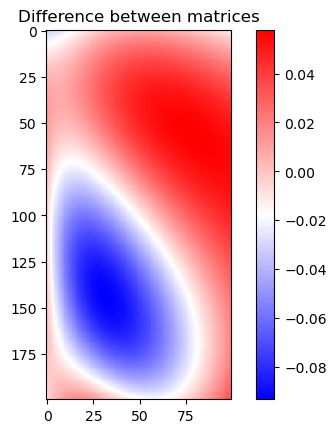

In [16]:
matrix_diff=y_real-arr_y1
# Affichage de la différence
plt.title('Difference between matrices')
plt.imshow(matrix_diff, cmap='bwr', interpolation='nearest')  # Utilisation d'une colormap divergente pour voir les écarts positifs/négatifs
plt.colorbar()
plt.show()